# DSCI100 Group Project - 004-4

## Introduction

Minecraft is a sandbox game made of blocks launched by Mojang Studios in 2011. There are lots of things to do in the game, from basic survival and building things from imagination, to collecting rare items and beating bosses, making minecraft a game suitable for all ages.

A research group in Computer Science at UBC, led by Frank Wood, set up a Minecraft server to collect data about players' actions and demographics. In this project, we are using their collected data (players.csv) to answer our question:

 **Can the age of players be used to predict their number of hours played on Minecraft?**

 We will be answering so by using a linear regression model, which is where a best-fitted line is placed on the graph that'll be used to give a prediction.


**Data description (players.csv):**

Number of rows: 196 <br>
Number of columns(variables):7 <br>
| Variables | Types of var| Meaning | Data collection method|
|-------|-----|---------|-----------|
| experience  | character  |  player's experience of playing minecraft, categorized into 5 levels: Amateur,Beginner,Pro, Regular, Veteran | self-report |
| subscribe | logical  | whether the player has subscribed to the Minecraft newsletter  |either self-report or linked to self-reported email|
| hashedEmail | character | user identification, hashed for privacy reasons   |self-reoprt, verified by player and server|
| played_hours | double | number of hours played on Minecraft |recorded on Minecraft server|
| name  | character | player's names |self-report|
| gender | character  | player's gender  |self-report|
| Age | double  | player's age  |self-report|

## Methods and Results


**Method to Perform Analysis**: We will be using a linear regression model to see the relation between played time (in hours) and how old someone it. We will first wrangle the data and clean it up so we only use the data neccessary, meaning we will get rid of N/As for age and any player who didn't play on the server at all. Then, we will split the data set up 75/25 in order to have training and testing data. Then we move on to visualizing it, and seeing how accurate this model could be (by calculating RMSE/RMSPE and seeing the error percentage by dividing it by the range). After that, we will make our observations and come to a conclusion of whether age can be something used to predict playing time. 

In [2]:
library(tidyverse)
library(janitor)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

download.file("https://raw.githubusercontent.com/GraySchi/DSCI-Project-004-Group4/refs/heads/main/players%20(2).csv", "players.csv")
players_data <- read_csv(file = "players.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ──────

In [11]:
head(players_data)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [12]:
cleaned_players <- players_data |>
    clean_names() |>
    select(age, played_hours) |>
    filter(!is.na(age)) |>
    filter(played_hours > 0)
head(cleaned_players)

summary(cleaned_players)

age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
21,0.7
21,0.1
47,0.1
23,1.6


      age        played_hours   
 Min.   : 9.0   Min.   :  0.10  
 1st Qu.:17.0   1st Qu.:  0.10  
 Median :20.0   Median :  0.50  
 Mean   :21.3   Mean   : 10.51  
 3rd Qu.:23.0   3rd Qu.:  1.80  
 Max.   :58.0   Max.   :223.10  

Here, we cleaned up the data, by removing age that's NA and removing those with 0 hours since there were so many, meaning they signed up but never played it which isn't necessarily useful for us.

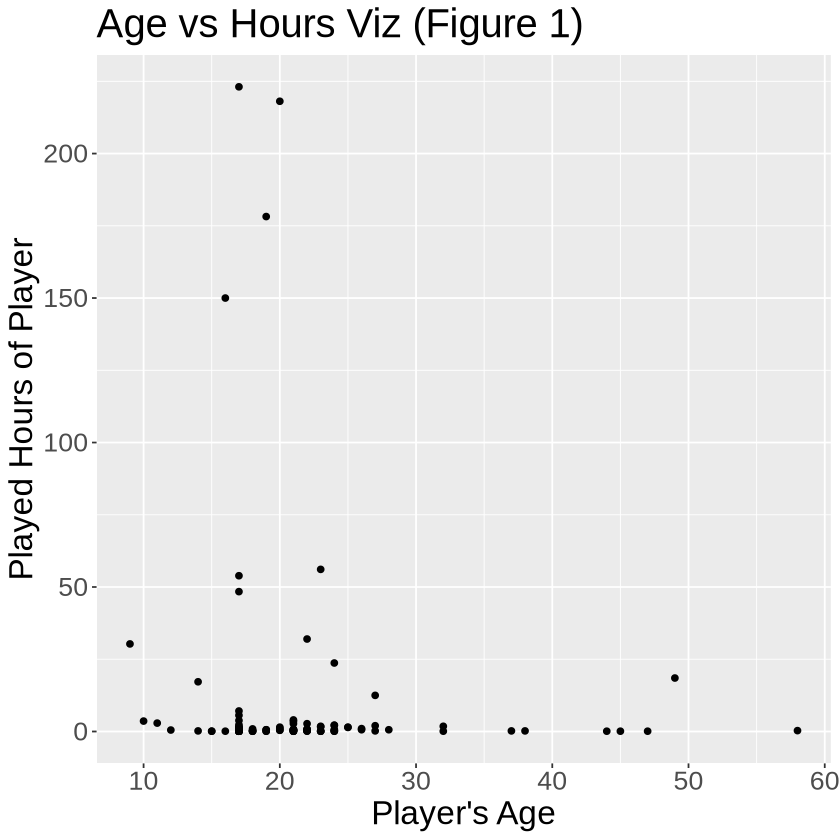

In [13]:
age_vs_hours_plot <- cleaned_players |>
    ggplot(aes(x=age, y=played_hours)) +
    geom_point() +
    labs(x="Player's Age", y="Played Hours of Player", title="Age vs Hours Viz (Figure 1)") +
    theme(text = element_text(size=20))
age_vs_hours_plot

As you can see from the graph, it is hard to see a relation between played_hours and age. To fix this we will make some modifications to the data by applying log and filtering out players who played 0 hours.

age,played_hours
<dbl>,<dbl>
9,3.44361810
17,1.56861592
21,0.53062825
21,0.09531018
47,0.09531018
23,0.95551145


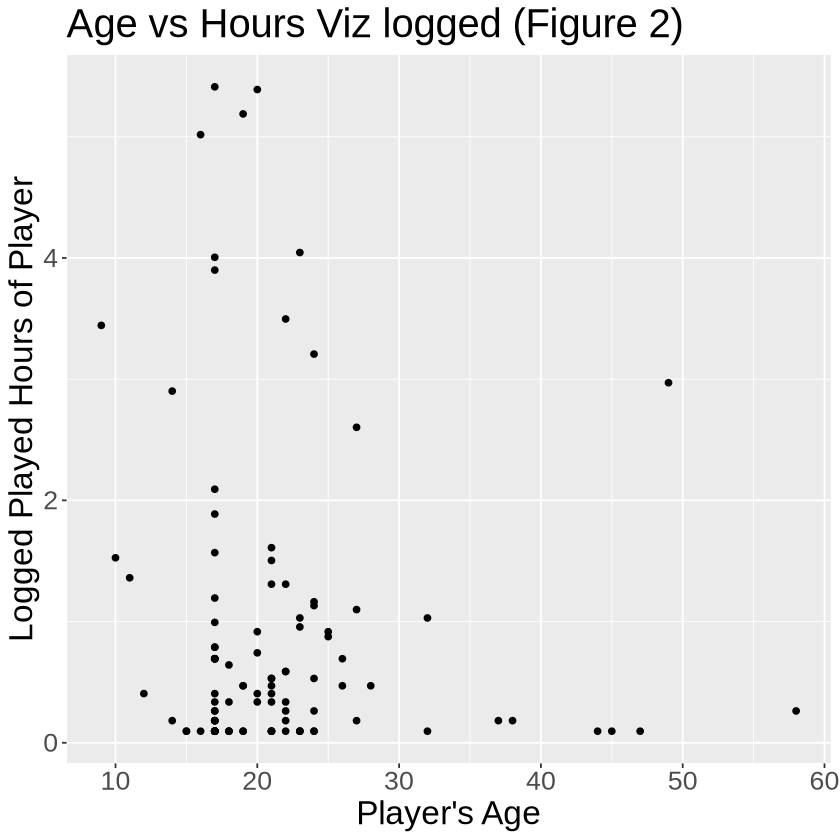

In [14]:
players_logged <- cleaned_players |>
    mutate(played_hours = log(played_hours + 1))
head(players_logged)

logged_plot <- players_logged |>
    ggplot(aes(x=age, y=played_hours)) +
    geom_point() +
    labs(x="Player's Age", y="Logged Played Hours of Player", title="Age vs Hours Viz logged (Figure 2)") +
    theme(text = element_text(size=20))
logged_plot

Here we see a better relation between played_hours and a players age. The graph seems to be right-skewed, with players around the age of 20 logging the highest hours.

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age  
    1.25964     -0.01438  


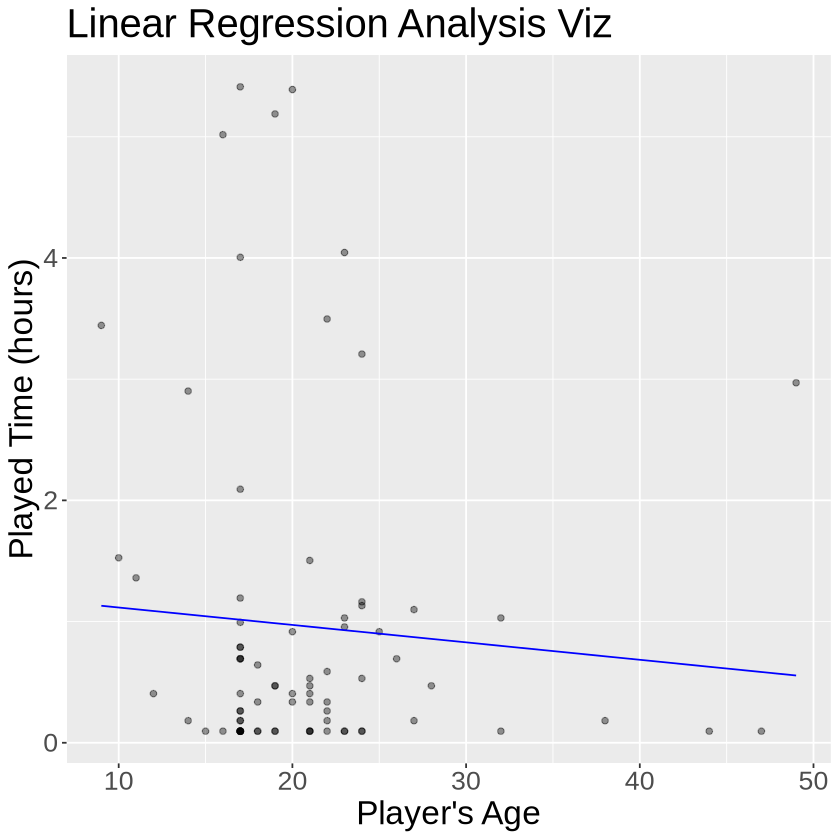

In [15]:
data_split <- initial_split(players_logged, 
                                prop = 0.75, 
                                strata = played_hours)

data_training <- training(data_split)
data_testing <- testing(data_split)

lm_spec <- linear_reg() |>
      set_engine("lm") |>
      set_mode("regression")

lm_recipe <- recipe(played_hours ~ age, data = data_training)

lm_fit <- workflow() |>
       add_recipe(lm_recipe) |>
       add_model(lm_spec) |>
       fit(data_training)
lm_fit

data_preds <- lm_fit |>
  predict(data_training) |>
  bind_cols(data_training)

lm_predictions <- data_preds |>
    ggplot(aes(x = age, y = played_hours)) +
        geom_point(alpha = 0.4) +
        geom_line(
            mapping = aes(x = age, y = .pred), 
            color = "blue") +
        xlab("Player's Age") +
        ylab("Played Time (hours)") +
        ggtitle("Linear Regression Analysis Viz") +
        theme(text = element_text(size = 20))
lm_predictions

In [16]:
lm_rmse <- data_preds |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(-.estimator)
lm_rmse

.metric,.estimate
<chr>,<dbl>
rmse,1.351462


Our $RMSPE$ is 1.25. However, this is in its logarithmic state, so we must solve back for how far off our played_hours is. Since $log(x+1)=y$   -|-   $x= e^y-1$. In this case $y$ is our $RMSPE$.

In [17]:
exp(1.247537) - 1

[1] 2.481757

Our model has a test error of 2.48 hours.

**Now we'll be looking at the testing data**

.estimate
<dbl>
1.349263


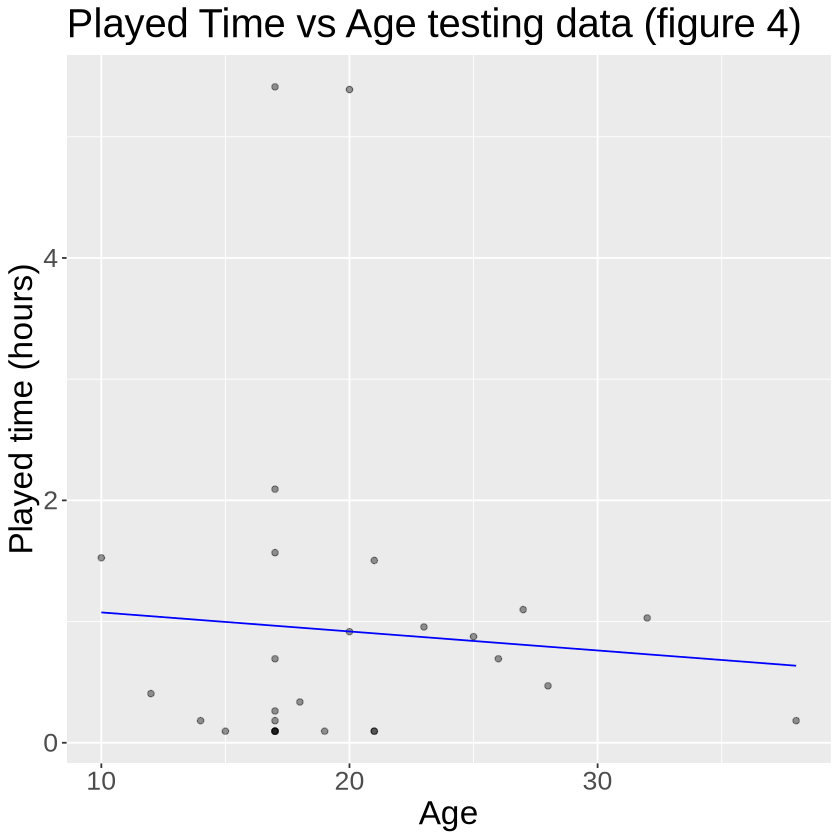

In [45]:
lm_test_results <- lm_fit |>
        predict(data_testing) |>
        bind_cols(data_testing) |>
        metrics(truth = played_hours, estimate = .pred)

lm_rmspe <- lm_test_results |>
        filter(.metric == "rmse") |>
        select(.estimate)
lm_rmspe


test_preds <- lm_fit |>
  predict(new_data = testing(data_split)) |>
  bind_cols(testing(data_split))

lm_predictions_test <- test_preds |>
  ggplot(aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(aes(y = .pred), color = "blue") +
  labs(
    title = "Played Time vs Age testing data (figure 4)",
    x = "Age",
    y = "Played time (hours)"
  ) +
  theme(text = element_text(size = 20))

# Display the plot
lm_predictions_test

Now we do the same with the rmspe, to convert it back into hours from the logged state:

In [47]:
exp(1.349263) - 1

[1] 2.854584

In [48]:
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age  
    1.23245     -0.01571  


## Discussion

We found that age and played_hours have a negative relationship which can be modelled by $Predicted \ Played \ time \ (in \ hours) = 1.23 - 0.016  * age \ (in \ years)$. Meaning the older a person is, the less likely they are to play a lot of Minecraft. Since our original range of played_hours was 223.1, that means our test data has an error of 1.28% (Using the RMPSE divided by the range to get the percentage that the error is at). That means the testing data is pretty accurate, thus we're able to infer that age may be used to predict a player's playing time. We expected this to be the case, as younger people tend to be more interested in video games and often have more time to play them. Plus, Minecraft is launched in 2011. Kids from that generation would play minecraft the most, and some would keep playing as time passed. This explains why the younger generation plays Minecraft more, and aligns with the mean age of the Minecraft players, 21.3, as 14 years ago they would be ~7 years old.

These findings could impact a video game company to direct its advertising towards the younger generation, as they have a higher likelihood of playing. In the future, using the findings here, we could be looking to see what factors play into the younger demographic playing more, or if transitions into different phases of life (fromt high school to university or going into work) have an affect on gaming. It could also spark questions about how the trend would change as the younger people now continue to play minecraft in the future and change the age vs played_hours relationship as they grow older.